In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
font = {'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for client in data['results']:
                for line in client['stdout_lines']:
                    if "started" in line: start = line.split()[4]
                    if "finished" in line: end = line.split()[4]            
                r.append(to_seconds(end) - to_seconds(start))
    return r

def parse_delta(files):
    r = []; o = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)       
            r.append(to_seconds(data['delta']))
            try:
                o.append(float(data['stdout']))
            except:
                o.append(0)
    return r, o

def label(string):
    if 'nojournal' in string:
        return "No\nJournal"
    return string.replace("journal", '')

,job,mean,std
0,No\nJournal,1.000000,0.032575
1,30,1.405959,0.023629
2,60,1.338920,0.050862
3,90,1.301676,0.029029
4,120,1.280261,0.043772
5,150,1.250466,0.028149
6,180,1.257914,0.029940


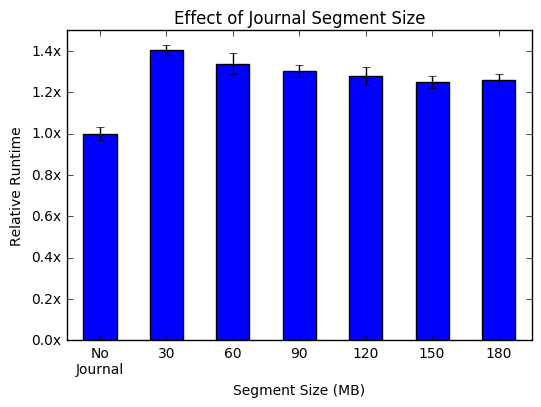

In [3]:
mean = 0
df = pd.DataFrame(columns=["job", "mean", "std"])
for s in ["nojournal", "journal30", "journal60", "journal90",
          "journal120", "journal150", "journal180"]:
    d = parse_mdtest(glob.glob('../results0/' + s + '-cache/' + 'mdtest-100000-*'))
    if mean == 0: mean = np.mean(d)
    df.loc[len(df)] = [label(s), np.mean(d/mean), np.std(d/mean)]

fig, ax = plt.subplots(1, 1)
df.plot.bar(ax=ax, y='mean', yerr='std')
ax.legend().remove()
ax.set_title("Effect of Journal Segment Size")
ax.set_ylabel("Relative Runtime")
ax.set_ylim(0, 1.5)
ax.set_xlabel("Segment Size (MB)")
ax.set_xticklabels(df['job'], rotation=0)
ax.set_yticklabels(['{:3.1f}x'.format(y) for y in ax.get_yticks()])
fig.savefig('../../../paper/figures/slowdown-journal.png', bbox_inches='tight', dpi=400)
df